In [4]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

In [5]:
future_property = {
    # numeric / binary features
    "Width":  5,
    "Length": 20,
    "Floors": 0,
    "Rooms":  0,
    "Toilets": 0,

    # boolean flags
    "1 Part Residential": 0,
    "All Residential":    1,
    "Back Expansion":     0,
    "Car Alley":          1,
    "Frontage":           1,
    "No Residential":     0,

    # category one-hot
    "Category_HOUSE":     0,
    "Category_LAND":      1,
    
    # district one-hot
    "District_Huyện Hòa Vang":    0,
    "District_Quận Cẩm Lệ":       1,
    "District_Quận Hải Châu":     0,
    "District_Quận Liên Chiểu":   0,
    "District_Quận Ngũ Hành Sơn": 0,
    "District_Quận Sơn Trà":      0,
    "District_Quận Thanh Khê":    0,

    # direction one-hot
    "House Direction_EAST":      1,
    "House Direction_NORTH":     0,
    "House Direction_NORTHEAST": 0,
    "House Direction_NORTHWEST": 0,
    "House Direction_SOUTH":     0,
    "House Direction_SOUTHEAST": 0,
    "House Direction_SOUTHWEST": 0,
    "House Direction_WEST":      0,

    # furnishing one-hot
    "Furnishing Sell_BASIC_FINISHING":    0,
    "Furnishing Sell_FULLY_FURNISHED":    0,
    "Furnishing Sell_HIGH_END_FURNITURE": 0,
    "Furnishing Sell_RAW_HANDOVER":       0,
    
    "Land Type_AGRICULTURAL_LAND": 0,
    "Land Type_INDUSTRIAL_LAND":   0,
    "Land Type_PROJECT_LAND":      0,
    "Land Type_RESIDENTIAL_LAND":  1,
}

# Read log transformation parameters if available
try:
    scaler_params = pd.read_csv('forecast_scaler_params.csv', index_col='Metric')
    # Không cần min_price và max_price nữa vì chúng ta dùng log transform
    # Nếu có thông số khác cần thiết cho log transform, đọc vào đây
except:
    # Use default values if file can't be read
    print("Không thể đọc tham số log transform, sử dụng phương pháp log trực tiếp")

# Define a function to add time features
def add_time_features(base_features, date):
    f = base_features.copy()

    f['year'] = date.year
    f['month'] = date.month
    f['day'] = date.day
    f['dayofweek'] = date.weekday()
    f['quarter'] = date.quarter

    # Add cyclical features with CORRECT names
    f['month_sin'] = np.sin(2 * np.pi * date.month / 12)
    f['month_cos'] = np.cos(2 * np.pi * date.month / 12)
    f['dayOfWeek_sin'] = np.sin(2 * np.pi * f['dayofweek'] / 7)
    f['dayOfWeek_cos'] = np.cos(2 * np.pi * f['dayofweek'] / 7)

    return f

# Load trained model
final_model = None
try:
    model_file = 'xgboost_final_model.pkl'
    print(f"Loading model from {model_file}...")
    final_model = pickle.load(open(model_file, "rb"))
    print("Model loaded successfully")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Cannot continue prediction without a trained model")
    import sys
    sys.exit()

# Check if model was loaded successfully
if final_model is None:
    print("Model not loaded successfully")
    import sys
    sys.exit()

# Calculate area
# future_property['Area'] = future_property['Length'] * future_property['Width']

# Forecast start date: today
start_date = pd.Timestamp.now().normalize()

results = []

# Normalize numerical features using square root
numerical_features = ['Length', 'Width', 'Area', 'Floors', 'Rooms', 'Toilets']
for feature in numerical_features:
    if feature in future_property:
        future_property[feature] = np.sqrt(future_property[feature])

# Store real area before square root for total value calculation
real_area = 20 * 5  # Length * Width before square root

# Predict for the next 90 days
for i in range(90):
    date = start_date + timedelta(days=i)

    # Combine static and time features
    f = add_time_features(future_property, date)

    # Convert dictionary to DataFrame for prediction
    X_pred = pd.DataFrame([f])

    # Predict
    pred_price = final_model.predict(X_pred)[0]

    # Reverse log normalization using exponential function
    denormalized_price = np.exp(pred_price)

    results.append({
        'Date': date,
        'Predicted_Price_per_m2': denormalized_price
    })

# Create result DataFrame
forecast_df = pd.DataFrame(results)

# Display results
print("First 5 days of predictions:")
print(forecast_df.head())

print("\nLast 5 days of predictions:")
print(forecast_df.tail())

# Calculate total property value based on area
forecast_df['Total_Property_Value'] = forecast_df['Predicted_Price_per_m2'] * real_area

print("\nTotal property value (first 5 days):")
print(forecast_df[['Date', 'Predicted_Price_per_m2', 'Total_Property_Value']].head())

Loading model from xgboost_final_model.pkl...
Model loaded successfully
First 5 days of predictions:
        Date  Predicted_Price_per_m2
0 2025-05-07               44.364334
1 2025-05-08               43.535561
2 2025-05-09               42.854607
3 2025-05-10               43.133011
4 2025-05-11               44.220608

Last 5 days of predictions:
         Date  Predicted_Price_per_m2
85 2025-07-31               35.713036
86 2025-08-01               38.443092
87 2025-08-02               38.415173
88 2025-08-03               39.001911
89 2025-08-04               39.970974

Total property value (first 5 days):
        Date  Predicted_Price_per_m2  Total_Property_Value
0 2025-05-07               44.364334           4436.433594
1 2025-05-08               43.535561           4353.556152
2 2025-05-09               42.854607           4285.460449
3 2025-05-10               43.133011           4313.301270
4 2025-05-11               44.220608           4422.060547


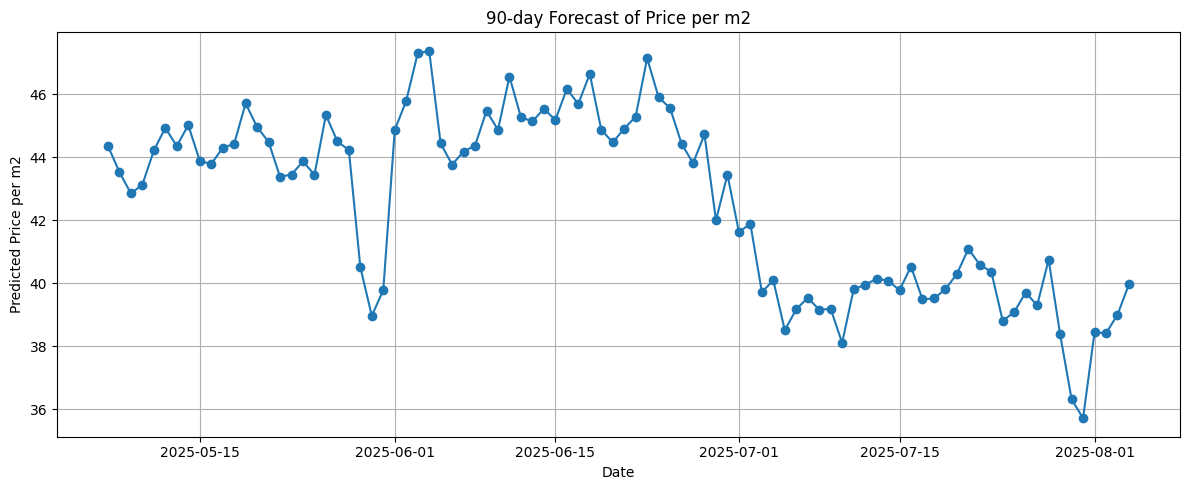

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(forecast_df['Date'], forecast_df['Predicted_Price_per_m2'], marker='o')
plt.title('90-day Forecast of Price per m2')
plt.xlabel('Date')
plt.ylabel('Predicted Price per m2')
plt.grid(True)
plt.tight_layout()
plt.show()
